## Application of CNN on X-Rays

This repository investigates the application of convolutional neural networks on x-ray images in order to properly diagnose the patient. The details of the dataset will be displayed within the notebook as we progress.

### Imports

In [10]:
import cv2
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

### Load Data

In [2]:
# image path 
images = glob('../images/*.png')

# load labels
labels = pd.read_csv('../sample_labels.csv')

In [3]:
labels.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


### Exploration
Discover what are the possible diseases present in the dataset.

In [4]:
# split the diagnosis then visualize its histogram
diseases = list(labels['Finding Labels'])
diseases = [x for dis in diseases for x in dis.split("|")]

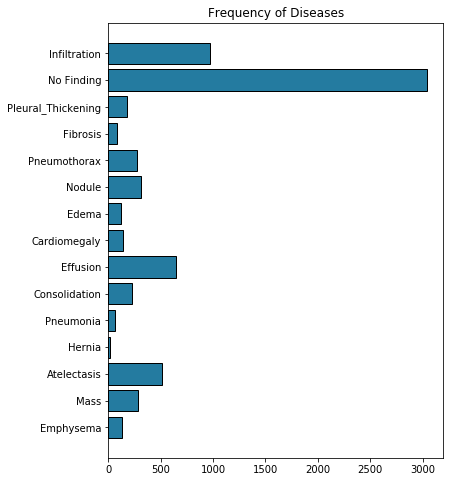

In [5]:
% matplotlib inline

keys, values = zip(*Counter(diseases).items())

indexes = np.arange(len(keys))

fig = plt.figure(figsize=(6,8))
plt.title('Frequency of Diseases')
plt.barh(indexes, values, color='#247ba0', edgecolor='black')
plt.yticks(indexes, keys)
plt.show()

### Data Preperation
For this purpose, I will relabel tha data to a binary class. Class 0 represents images with `No Finding` and class 1 are the rest of the images. In other words, I formulated the problem to identify whether the x-ray image has a finding or not.

In [6]:
disease = "No Finding"

x = [] # images as arrays
y = [] # labels

# resizing images
WIDTH = 128
HEIGHT = 128

for img in tqdm(images):
    path = img.split('/')[-1]
    finding = labels["Finding Labels"][labels["Image Index"] == path].values[0]

    # read and resize image
    full_size_image = cv2.imread(img)
    try:
        x.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
    except:
        continue

    # label 'no finding'
    if disease in finding:
        finding = 0
        y.append(finding)

    # label 'has finding'
    else:
        finding = 1
        y.append(finding)

100%|██████████| 5606/5606 [04:30<00:00, 20.73it/s]  


### Split Data

* training: 80%
* testing: 20%

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, shuffle=True)

In [11]:
# normalize inputs from 0-255 and 0.0-1.0
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print("Data normalized and hot encoded.")

Data normalized and hot encoded.


In [8]:
# print training & test examples
print(np.array(X_train).shape)
print(np.array(X_test).shape)

(4484, 128, 128, 3)
(1122, 128, 128, 3)


### Construct CNN Architecture

In [22]:
 # create the model
model = Sequential()
model.add(Convolution2D(32, 3, strides=3, input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, strides=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile model
epochs = 25
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 43, 43, 32)        896       
_________________________________________________________________
dropout_13 (Dropout)         (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               803328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
__________

In [23]:
# fit and run our model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=64)

# final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 4484 samples, validate on 1122 samples
Epoch 1/25
4484/4484 [==============================] - 6s 1ms/step - loss: 0.7060 - acc: 0.5314 - val_loss: 0.6846 - val_acc: 0.5989
Epoch 2/25
4484/4484 [==============================] - 5s 1ms/step - loss: 0.6758 - acc: 0.5747 - val_loss: 0.6756 - val_acc: 0.5677
Epoch 3/25
4484/4484 [==============================] - 5s 1ms/step - loss: 0.6621 - acc: 0.6082 - val_loss: 0.6610 - val_acc: 0.6087
Epoch 4/25
4484/4484 [==============================] - 5s 1ms/step - loss: 0.6574 - acc: 0.6140 - val_loss: 0.6619 - val_acc: 0.5838
Epoch 5/25
4484/4484 [==============================] - 5s 1ms/step - loss: 0.6522 - acc: 0.6276 - val_loss: 0.6636 - val_acc: 0.6212
Epoch 6/25
4484/4484 [==============================] - 5s 1ms/step - loss: 0.6458 - acc: 0.6325 - val_loss: 0.6552 - val_acc: 0.6337
Epoch 7/25
4484/4484 [==============================] - 5s 1ms/step - loss: 0.6449 - acc: 0.6347 - val_loss: 0.6583 - val_acc: 0.6283
Epoch 8/25
448